In [1]:
import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np


In [2]:
dim_input = 1

class NNApproximator(nn.Module):
  def __init__(self, dim_input = 1, dim_output = 1, num_hidden = 2, dim_hidden = 1, activation=nn.Tanh()):
    super().__init__()

    self.layer_in = nn.Linear(dim_input, dim_hidden)
    self.layer_out = nn.Linear(dim_hidden, dim_output)

    num_middle = num_hidden - 1
    self.middle_layers = nn.ModuleList(
        [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
    )
    self.activation = activation

  def forward(self, t):
    out = self.activation(self.layer_in(t))
    for layer in self.middle_layers:
      out = self.activation(layer(out))
    return self.layer_out(out)

In [3]:
def f(model, t):
  """Evaluate a neural network with the input x."""
  return model.forward(t)

def df(model, t, order=1):
  """Compute the neural network's derivative wrt the input, x, using autograd."""
  df_value = f(model, t)
  for _ in range(order):
    df_value = torch.autograd.grad(
        outputs=df_value,
        inputs=t,
        grad_outputs=torch.ones_like(t),
        create_graph=True,
        retain_graph=True,
    )[0]

  # TODO: need to figure out what the [0] is for, and why the Jv product uses v=ones()

  return df_value

def compute_PINN_loss(model, t, x_tr):
  omega = -0.1
  t_bc = 0.0    # input value where boundary condition is specified
  x_bc = 1.0    # value of f at the boundary condition

  # using training data... the canonical method is NOT to do this, but use the NN's variables wherever possible.
  # Since the NN predicts x(t), we should use model.forward(t) instead of the training data x_tr.
  # ode_residual = df(model, t) - omega * x_tr
  ode_residual = df(model, t) - omega * f(model, t)
  ode_loss = 0.5 * torch.mean(ode_residual ** 2)

  t_bc = torch.tensor([t_bc], requires_grad=False)
  x_bc = torch.tensor([x_bc], requires_grad=False)
  x_bc_nn = f(model, t_bc)
  bc_loss = 0.5 * (x_bc_nn - x_bc) ** 2

  return ode_loss + bc_loss

In [4]:
def compute_data_loss(model, t_tr, x_tr):
  return 0.5 * torch.mean((f(model, t_tr) - x_tr) ** 2)

In [5]:
def train_model(model, data_loss_fn, PINN_loss_fn, learning_rate=0.01, max_epochs=1000):
  tr_losses = []
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  
  for epoch in range(max_epochs):
    loss = data_loss_fn(model) + PINN_loss_fn(model)    # TODO: how/where to include x and data (y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
      print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")
    tr_losses.append(loss.detach().numpy())

  return model, np.array(tr_losses)

Epoch: 0 - Loss: 0.315772
Epoch: 1000 - Loss: 0.000194
Epoch: 2000 - Loss: 0.000040
Epoch: 3000 - Loss: 0.000016
Epoch: 4000 - Loss: 0.000010


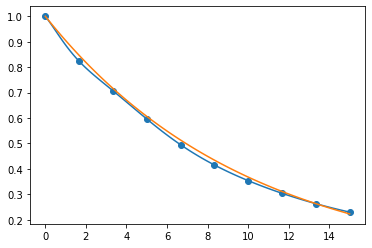

In [6]:
domain = [0.0, 15.0]
# requires grad because this is the input vector to the NN
t_tr = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True)
t_tr = t_tr.reshape(-1, 1)

# x_tr is derived from t_tr, but it's not differentiated in any of the loss computations. requires_grad=False.
x_tr = torch.exp(-0.1 * t_tr.detach()).reshape(t_tr.shape)
x_tr.requires_grad = False

nn_approximator = NNApproximator(1,1,4,10)
# assert check_gradient(nn_approximator, x)

nn_tr, tr_losses = train_model(
    nn_approximator,
    data_loss_fn=lambda model: 0, #compute_data_loss(model, t_tr, x_tr),
    PINN_loss_fn=lambda model: compute_PINN_loss(model, t_tr, x_tr),
    learning_rate=0.1,
    max_epochs=5000,
)


t_eval = torch.linspace(domain[0],domain[1],steps=100, requires_grad=False).reshape(-1,1)

f_tr = f(nn_tr, t_tr)
f_eval = f(nn_tr, t_eval)

plt.scatter(t_tr.detach().numpy(), f_tr.detach().numpy(), label='Colloc. points')
plt.plot(t_eval.detach().numpy(), f_eval.detach().numpy(), label='NN solution')
plt.plot(t_eval.detach().numpy(), torch.exp(-0.1*t_eval).detach().numpy(),label='Truth')
